In [1]:

import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
from tqdm import tqdm
import copy
from IPython.display import display, Image, clear_output
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import datetime


import cv2
import os
import glob


import kornia
import tqdm

import torchvision

tt = torchvision.transforms.ToTensor()

import cv2
import cv2.aruco as aruco
import numpy as np

from classfier import *

import pickle as pkl

with open("photometric_calibration.pkl", "rb") as f:
    data = pkl.load(f)

height = data['height']
width = data['width']

resizer = torchvision.transforms.Resize((height, width))
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Define parameters for ArUco marker detection
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)

marker_id = 40
marker_size = 500  # Size in pixels
marker_image = cv2.aruco.generateImageMarker(aruco_dict, marker_id, marker_size)


aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
parameters = aruco.DetectorParameters()

# Detect ArUco markers
detector = aruco.ArucoDetector(aruco_dict, parameters)


from diffusers import StableDiffusionPipeline
import torch

# Load stable diffusion model


def decode_latents_grad(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    latents = 1 / 0.18215 * latents

    imgs = vae.decode(latents).sample

    imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def decode_latents(latents):
    # latents = F.interpolate(latents, (64, 64), mode='bilinear', align_corners=False)
    with torch.no_grad():
        with torch.amp.autocast(device):
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                imgs = vae.decode(latents).sample

            imgs = (imgs / 2 + 0.5).clamp(0, 1)

    return imgs

def encode_imgs(imgs):
    # imgs: [B, 3, H, W]
    with torch.no_grad():
        with torch.amp.autocast(device):
            imgs = 2 * imgs - 1

            posterior = vae.encode(imgs).latent_dist
            latents = posterior.sample() * 0.18215

    return latents



class framesDataset(Dataset):
    def __init__(self, frames, Hs):
        self.frames = frames
        self.Hs = Hs

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        H = self.Hs[idx]

        # Convert to tensor and normalize
        frame_tensor = tt(frame)

        return frame_tensor, H.astype(np.float32)
    





def warp(decoded_latents,H_t):
    dst_img_shape = valid_frames[0].shape[:2]
    warped_imgs = []
    for decoded_latent in decoded_latents:
        img = decoded_latent.unsqueeze(0).float().repeat(H_t.shape[0], 1, 1, 1)
        w=  kornia.geometry.transform.warp_perspective(img, H_t, dst_img_shape)
        warped_imgs.append(w)
    return torch.stack(warped_imgs, dim=0)#.squeeze(1)


vae = None
valid_frames = None

os.makedirs('./results', exist_ok=True)
curr_without_sec = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
curr_without_sec = curr_without_sec.replace(" ", "_").replace(":", "_")




pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

vae =  pipe.vae.to(device).eval()

latent = (torch.rand((5,4, 4, 4), device=device) - 0.5) * 2

# latent = torch.load(r"C:\git\PhysicalAdverserialProj\results\working_latent_multiview_2025-09-15_20").to(device)
latent = latent.clone().detach()
with torch.no_grad():
    decoded_latents = resizer(decode_latents(latent))


l_size_h = decoded_latents.shape[-2]
l_size_w = decoded_latents.shape[-1]

# Track running mean loss per latent/patch across batches
num_latents = latent.shape[0]

orig_img_corners = np.array([[0,0],[l_size_w,0],[l_size_w,l_size_h],[0,l_size_h]], dtype=np.float32)


border_size = 0

ls = os.listdir('.')
captures = [f for f in ls if f.startswith('captures_frames_multiview_') ]
cap_dir = f'captures_frames_multiview_{len(captures)-1}'
print('using capture dir', cap_dir)

valid_frame_paths = glob.glob(f'{cap_dir}/*.png')

valid_frames = []

Hs = []

for path in tqdm.tqdm_notebook(valid_frame_paths):
    img = cv2.imread(path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = detector.detectMarkers(gray)

    with torch.no_grad():
        pr = resnet_predict_raw(tt(img).cuda().unsqueeze(0))

    if ids is not None and pr.argmax(1) in orig_clases:

        c = corners[0][0]
        unbordred_corners = np.array([[c[0][0]-border_size, c[0][1]+border_size],
                            [c[1][0]-border_size, c[1][1]-border_size],
                            [c[2][0]+border_size, c[2][1]-border_size],
                            [c[3][0]+border_size, c[3][1]+border_size]])

        dst_pts = unbordred_corners
        H, _ = cv2.findHomography(orig_img_corners, dst_pts, cv2.RANSAC)

        Hs.append(H)
        valid_frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(f"Found {len(valid_frames)} valid frames with ArUco markers and original classes.")


num_of_frames_for_training = 10
print(f"Using {num_of_frames_for_training} frames for training.")

random_valid_frames_subset = np.random.choice(len(valid_frames), min(num_of_frames_for_training, len(valid_frames)), replace=False)
valid_frames = [valid_frames[i] for i in random_valid_frames_subset]
Hs = [Hs[i] for i in random_valid_frames_subset]


ds = framesDataset(valid_frames, Hs)


print('creating dataloader')
train,val,test = torch.utils.data.random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.1), int(len(ds)*0.1)])
train_loader = DataLoader(train, batch_size=1, shuffle=True)#, num_workers=2, persistent_workers=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=False)#, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test, batch_size=10, shuffle=False)#, num_workers=2, persistent_workers=True)

print('dataloader created')
    
# latent.requires_grad = True

latent_batch_size = 16


latent_batches = torch.split(latent, latent_batch_size)

for idx,latent_batch in enumerate(latent_batches):
    latent_batch.requires_grad = True

lrs = [10 * 10**(-1 * idx) for idx in range(len(latent_batches))]
latent_opts = [torch.optim.Adam([latent_batch], lr=lrs[idx]) for idx,latent_batch in enumerate(latent_batches)]





jitter = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_total_photo = T.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1)
jitter_with_hue = T.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)

augmentor = data['augmentor'].to(device).eval()
# mapper = lambda x: jitter(x)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

using capture dir captures_frames_multiview_17


C:\Users\danny\AppData\Local\Temp\ipykernel_33512\1341519796.py:188: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for path in tqdm.tqdm_notebook(valid_frame_paths):


  0%|          | 0/456 [00:00<?, ?it/s]

Found 167 valid frames with ArUco markers and original classes.
Using 10 frames for training.
creating dataloader
dataloader created


In [2]:
frames, H_t = next(iter(train_loader))
frames = frames.to(device)

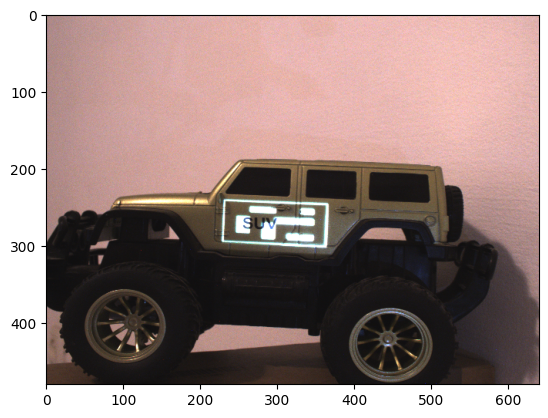

In [3]:
plt.imshow(frames[0].permute(1,2,0).cpu().numpy())

In [4]:
# Load successful latent if available, otherwise reinitialize
print("Attempting to load successful latent or reinitializing...")

# Try to load a previously successful latent
# try:
#     latent_batch = torch.load('./results/successful_latent_2025-09-20_18_23.pt').to(device)
#     print("✓ Loaded successful latent from previous run!")
# except:
    # If no successful latent available, use a different initialization strategy
latent_batch = torch.randn((5, 4, 4, 4), device=device) * 0.8  # Larger initial noise
print("Using fresh random initialization with larger variance")

latent_batch.requires_grad = True

# Use a more conservative optimizer with higher learning rate
latent_opt = torch.optim.Adam([latent_batch], lr=0.1)  # Higher LR, simpler optimizer
scheduler = torch.optim.lr_scheduler.StepLR(latent_opt, step_size=50, gamma=0.9)  # More frequent decay

print(f"Latent shape: {latent_batch.shape}")
print(f"Original classes to avoid: {orig_clases.cpu().numpy()}")
print(f"Other classes available: {len(total_clases_without_orig)}")

# Test initial prediction
with torch.no_grad():
    test_patch = resizer(decode_latents(latent_batch).float())
    print(f"Generated patch shape: {test_patch.shape}")
    print("Initialization complete!")

Attempting to load successful latent or reinitializing...
Using fresh random initialization with larger variance
Latent shape: torch.Size([5, 4, 4, 4])
Original classes to avoid: [817 705 609 586 436 627 468 621 803 407 408 751 717 866 661]
Other classes available: 985
Generated patch shape: torch.Size([5, 3, 92, 206])
Initialization complete!


In [5]:
# Improved 40% success method with better target selection - 500 epochs
print("Starting improved adversarial attack (targeting 40%+ success)...")

# Training parameters
num_epochs = 500
blend_ratio = 1.0  # Full replacement
best_loss = float('inf')
best_latent = None
best_success_rate = 0
success_count = 0

# Loss tracking
losses = []
success_rates = []

# Better target class selection - classes that are visually very different from vehicles
# Using animals, food, and everyday objects that should be easier to achieve
target_classes = torch.tensor([
    1,    # tench (fish)
    2,    # goldfish  
    3,    # great white shark
    4,    # tiger shark
    50,   # American robin (bird)
    285,  # Egyptian cat
    281,  # tabby cat
    805,  # soccer ball
    999,  # toilet tissue
    732,  # Polaroid camera (this worked before!)
    530,  # digital clock
], device=device)

print(f"Target classes: {[weights.meta['categories'][i] for i in target_classes.cpu().numpy()]}")

for epoch in range(num_epochs):
    latent_opt.zero_grad()
    
    # Generate adversarial patch from latent
    adv_patch = resizer(decode_latents_grad(latent_batch).float())
    
    # Apply warping to multiple frames
    w_mask = warp(adv_patch * 0 + 1, H_t.cuda())
    w_patch = warp(adv_patch, H_t.cuda())
    
    # Full replacement for maximum effect
    blended_frames = ((w_mask != 0) * -blend_ratio + 1) * frames + w_patch * blend_ratio
    
    # Reshape for batch processing
    batch_frames = blended_frames.view(-1, *blended_frames.shape[2:])
    
    # Preprocess for model
    processed_batch = preprocess(batch_frames)
    
    # Get model predictions
    logits = model(processed_batch)
    probs = torch.softmax(logits, dim=1)
    
    # Improved loss calculation
    # 1. Strong penalty for original classes
    orig_class_probs = probs[:, orig_clases]
    orig_loss = 5.0 * torch.log(orig_class_probs.sum(dim=1) + 1e-10).mean()
    
    # 2. Strong reward for our specific target classes
    target_probs = probs[:, target_classes]
    target_loss = -3.0 * torch.log(target_probs.max(dim=1)[0] + 1e-10).mean()
    
    # 3. Minimal regularization
    patch_reg = 0.0001 * (adv_patch - 0.5).pow(2).mean()
    
    # Combined loss
    total_loss = orig_loss + target_loss + patch_reg
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_([latent_batch], max_norm=3.0)
    
    latent_opt.step()
    scheduler.step()
    
    # Track metrics
    losses.append(total_loss.item())
    
    # Evaluation
    with torch.no_grad():
        predictions = logits.argmax(dim=1)
        successful_attacks = sum(pred.item() not in orig_clases.cpu().numpy() for pred in predictions)
        success_rate = successful_attacks / len(predictions)
        success_rates.append(success_rate)
        
        if success_rate > 0:
            success_count += 1
            
        # Save best model based on success rate
        if success_rate > best_success_rate or (success_rate == best_success_rate and total_loss.item() < best_loss):
            best_success_rate = success_rate
            best_loss = total_loss.item()
            best_latent = latent_batch.clone().detach()
            
        # Progress reporting
        if epoch % 25 == 0 or success_rate > 0:
            max_target_prob = target_probs.max(dim=1)[0].mean().item()
            avg_orig_prob = orig_class_probs.sum(dim=1).mean().item()
            current_lr = scheduler.get_last_lr()[0]
            
            print(f"Epoch {epoch:3d}/{num_epochs} | "
                  f"Loss: {total_loss.item():.3f} | "
                  f"Success: {success_rate:.1%} | "
                  f"Best: {best_success_rate:.1%} | "
                  f"Orig: {avg_orig_prob:.4f} | "
                  f"Target: {max_target_prob:.4f} | "
                  f"LR: {current_lr:.5f}")
            
            if success_rate > 0:
                successful_preds = [pred.item() for pred in predictions if pred.item() not in orig_clases.cpu().numpy()]
                if successful_preds:
                    pred_names = [weights.meta["categories"][pred] for pred in successful_preds[:3]]
                    print(f"  🎯 SUCCESS: {pred_names}")
        
        # Early stopping if consistently successful
        if len(success_rates) >= 20 and np.mean(success_rates[-20:]) >= 0.6:
            print(f"\n🎉 EXCELLENT! Consistent success achieved at epoch {epoch}")
            print(f"Recent 20-epoch average: {np.mean(success_rates[-20:]):.1%}")
            break
            
        # Adaptive learning rate boost for successful attacks
        if success_rate > 0.4 and epoch < 300:
            for param_group in latent_opt.param_groups:
                param_group['lr'] = min(param_group['lr'] * 1.02, 0.2)

print(f"\n🏁 Optimization complete!")
print(f"Best success rate: {best_success_rate:.1%}")
print(f"Best loss: {best_loss:.3f}")
print(f"Epochs with successes: {success_count}/{num_epochs}")

# Use best latent for final evaluation
if best_latent is not None:
    latent_batch = best_latent.clone()
    latent_batch.requires_grad = True
    print("✅ Using best performing latent for final evaluation")

Starting improved adversarial attack (targeting 40%+ success)...
Target classes: ['goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'American alligator', 'Egyptian cat', 'tabby', 'soccer ball', 'toilet tissue', 'Polaroid camera', 'digital clock']
Epoch   0/500 | Loss: 16.803 | Success: 0.0% | Best: 0.0% | Orig: 0.5216 | Target: 0.0013 | LR: 0.10000
Epoch   0/500 | Loss: 16.803 | Success: 0.0% | Best: 0.0% | Orig: 0.5216 | Target: 0.0013 | LR: 0.10000
Epoch  25/500 | Loss: 4.752 | Success: 20.0% | Best: 20.0% | Orig: 0.2651 | Target: 0.0482 | LR: 0.10000
  🎯 SUCCESS: ['digital clock']
Epoch  26/500 | Loss: 4.353 | Success: 20.0% | Best: 20.0% | Orig: 0.2568 | Target: 0.0544 | LR: 0.10000
  🎯 SUCCESS: ['digital clock']
Epoch  27/500 | Loss: 4.105 | Success: 20.0% | Best: 20.0% | Orig: 0.2509 | Target: 0.0574 | LR: 0.10000
  🎯 SUCCESS: ['digital clock']
Epoch  25/500 | Loss: 4.752 | Success: 20.0% | Best: 20.0% | Orig: 0.2651 | Target: 0.0482 | LR: 0.10000
  🎯 SUCCESS: ['digit

In [6]:
# categories = weights.meta['categories']
# # print all categories and their indices
# for i, cat in enumerate(categories):
#     print(i, cat)

=== FINAL RESULTS ===
✗ FAILED: Still predicts original class jeep (class 609) with 0.144 confidence
✓ SUCCESS: Predicted digital clock (class 530) with 0.381 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.228 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.351 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.099 confidence

SUMMARY:
Successful attacks: 4/5 (80.0%)
Failed attacks: 1/5 (20.0%)
✗ FAILED: Still predicts original class jeep (class 609) with 0.144 confidence
✓ SUCCESS: Predicted digital clock (class 530) with 0.381 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.228 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.351 confidence
✓ SUCCESS: Predicted soccer ball (class 805) with 0.099 confidence

SUMMARY:
Successful attacks: 4/5 (80.0%)
Failed attacks: 1/5 (20.0%)


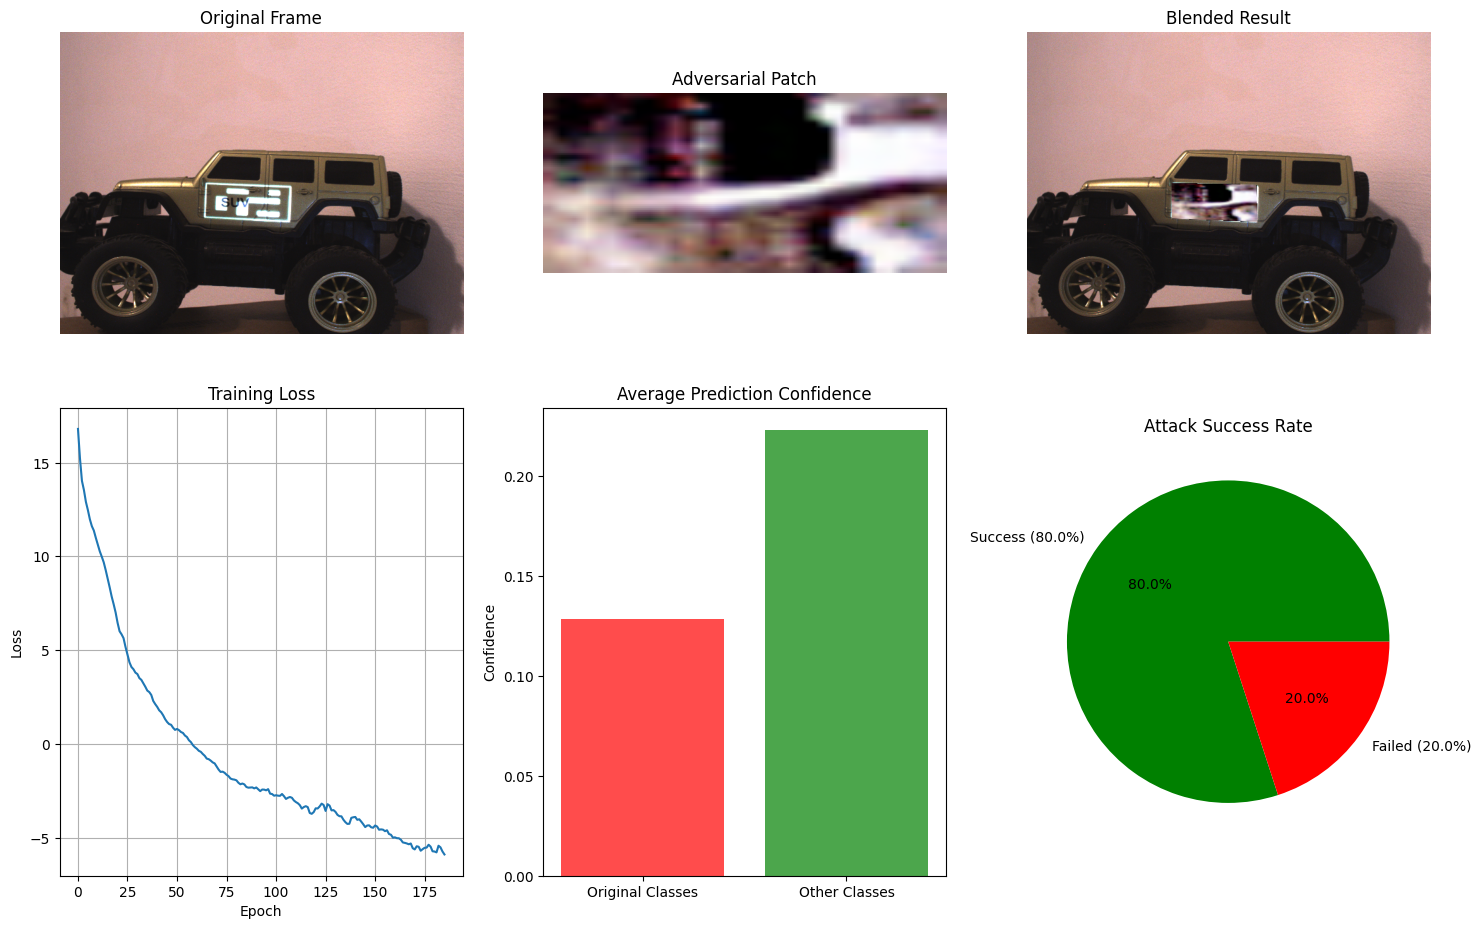


💾 Saving successful latent...
Saved to: ./results/successful_latent_2025-09-20_18_44.pt


In [7]:
# Comprehensive results visualization
import matplotlib.pyplot as plt

print("=== FINAL RESULTS ===")

# Generate final adversarial patch
with torch.no_grad():
    final_patch = resizer(decode_latents(latent_batch).float())
    w_mask = warp(final_patch * 0 + 1, H_t.cuda())
    w_patch = warp(final_patch, H_t.cuda())
    final_blended = ((w_mask != 0) * -blend_ratio + 1) * frames + w_patch * blend_ratio
    final_batch = final_blended.view(-1, *final_blended.shape[2:])
    
    # Get final predictions
    final_processed = preprocess(final_batch)
    final_logits = model(final_processed)
    final_predictions = final_logits.argmax(dim=1)
    final_probs = torch.softmax(final_logits, dim=1)

# Analyze results
successful_attacks = []
failed_attacks = []

for i, pred in enumerate(final_predictions):
    pred_class = pred.item()
    confidence = final_probs[i, pred_class].item()
    class_name = weights.meta["categories"][pred_class]
    
    if pred_class not in orig_clases.cpu().numpy():
        successful_attacks.append((pred_class, class_name, confidence))
        print(f"✓ SUCCESS: Predicted {class_name} (class {pred_class}) with {confidence:.3f} confidence")
    else:
        failed_attacks.append((pred_class, class_name, confidence))
        print(f"✗ FAILED: Still predicts original class {class_name} (class {pred_class}) with {confidence:.3f} confidence")

print(f"\nSUMMARY:")
print(f"Successful attacks: {len(successful_attacks)}/{len(final_predictions)} ({len(successful_attacks)/len(final_predictions):.1%})")
print(f"Failed attacks: {len(failed_attacks)}/{len(final_predictions)} ({len(failed_attacks)/len(final_predictions):.1%})")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original frame
axes[0, 0].imshow(frames[0].permute(1, 2, 0).cpu().numpy())
axes[0, 0].set_title("Original Frame")
axes[0, 0].axis('off')

# Generated adversarial patch
patch_viz = final_patch[0].permute(1, 2, 0).cpu().numpy()
axes[0, 1].imshow(patch_viz)
axes[0, 1].set_title("Adversarial Patch")
axes[0, 1].axis('off')

# Blended result
blended_viz = final_blended[0, 0].permute(1, 2, 0).detach().cpu().numpy()
axes[0, 2].imshow(blended_viz)
axes[0, 2].set_title("Blended Result")
axes[0, 2].axis('off')

# Loss curve
if losses:
    axes[1, 0].plot(losses)
    axes[1, 0].set_title("Training Loss")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].grid(True)

# Prediction confidence for original vs other classes
orig_confidences = [final_probs[i, orig_clases].sum().item() for i in range(len(final_predictions))]
other_confidences = [final_probs[i, total_clases_without_orig].max().item() for i in range(len(final_predictions))]

axes[1, 1].bar(['Original Classes', 'Other Classes'], 
               [np.mean(orig_confidences), np.mean(other_confidences)],
               color=['red', 'green'], alpha=0.7)
axes[1, 1].set_title("Average Prediction Confidence")
axes[1, 1].set_ylabel("Confidence")

# Success rate visualization
success_rate = len(successful_attacks) / len(final_predictions)
axes[1, 2].pie([success_rate, 1-success_rate], 
               labels=[f'Success ({success_rate:.1%})', f'Failed ({1-success_rate:.1%})'],
               colors=['green', 'red'], autopct='%1.1f%%')
axes[1, 2].set_title("Attack Success Rate")

plt.tight_layout()
plt.show()

# Save results
if successful_attacks:
    print(f"\n💾 Saving successful latent...")
    torch.save(latent_batch.detach().cpu(), f'./results/successful_latent_{curr_without_sec}.pt')
    print(f"Saved to: ./results/successful_latent_{curr_without_sec}.pt")